In [1]:
import sys
import importlib

import numpy as np

sys.path.append("/mnt/d/aspiranture/Satellite_Imagery_Analysis/Classification/")
import dataset_tool.dataset6_generator
importlib.reload(dataset_tool.dataset6_generator)

<module 'dataset_tool.dataset6_generator' from '/mnt/d/aspiranture/Satellite_Imagery_Analysis/Classification/dataset_tool/dataset6_generator.py'>

In [2]:
dataset = dataset_tool.dataset6_generator.get_dataset6()

Error read []
len 27


In [3]:
dataset.items

<function dict.items>

In [3]:
categories_map = {}
for categorie, idx in enumerate(dataset.keys()):
    categories_map[idx] = categorie+1

In [4]:
categories_map

{'water': 1, 'forest': 2, 'fields': 3, 'city': 4, 'sands': 5, 'mountains': 6}

In [5]:
updated_dataset = {}

for key, value in dataset.items():
    print(f"shape for {key} - {value.shape}")
    numOfRects = int(value.shape[1]/64/64)
    itemsDiff = value.shape[1]-numOfRects*64*64
    numOfFull = numOfRects*64*64
    itemsToAdd = 64*64-itemsDiff
    print(f"num of rects: {numOfRects}. To make full should add: {itemsToAdd}")
    if itemsToAdd > 0:
        values_sliced = value[:,:numOfFull]
        new_value = np.concatenate([value,values_sliced],axis=1)
        print(f"created new length with shape {new_value.shape}")
        updated_dataset[key] = values_sliced
    else:
        updated_dataset[key] = value


shape for water - (12, 6596993)
num of rects: 1610. To make full should add: 1663
created new length with shape (12, 13191553)
shape for forest - (12, 1532742)
num of rects: 374. To make full should add: 3258
created new length with shape (12, 3064646)
shape for fields - (12, 2099471)
num of rects: 512. To make full should add: 1777
created new length with shape (12, 4196623)
shape for city - (12, 574996)
num of rects: 140. To make full should add: 2540
created new length with shape (12, 1148436)
shape for sands - (12, 742139)
num of rects: 181. To make full should add: 3333
created new length with shape (12, 1483515)
shape for mountains - (12, 35420)
num of rects: 8. To make full should add: 1444
created new length with shape (12, 68188)


In [6]:
y_data_list = []
x_data_list = []

for key, value in updated_dataset.items():
    category_id = categories_map[key]
    arr = np.full(value.shape[1], category_id)
    y_data_list.extend(arr)
    x_data_list.append(value)
y_data = np.asarray(y_data_list)

In [7]:
y_data.shape

(11571200,)

In [8]:
x_data_1 = np.hstack(x_data_list)

In [9]:
x_data_1.shape

(12, 11571200)

In [10]:
x_data = np.moveaxis(x_data_1, 0,1)

In [11]:
print(f"Min {x_data.min()} and max {x_data.max()}")

Min 0.0 and max 1.7788000106811523


In [12]:
x_data.shape

(11571200, 12)

In [13]:
def createImageCubes(img_array, blk_width,blk_height):
    arrray = []
    imageShape = img_array.shape
    for w in range(0,imageShape[0],blk_width):
        for h in range(0, imageShape[1], blk_height):
            arrr = img_array[w:w+blk_width,h:h+blk_height]
            arrray.append(np.asarray(arrr))
    return np.asarray(arrray)

In [14]:
y_cubes = createImageCubes(y_data, 64,64)

IndexError: tuple index out of range

In [15]:
y_data.shape

(11571200,)

In [16]:
length = int(y_data.shape[0]/64/64)
length

2825

In [17]:
y_data_cubes = y_data.reshape(length,64,64)

In [18]:
x_data_cubes = x_data.reshape(length,64,64,12)

In [19]:
import tensorflow as tf

2023-09-28 12:52:31.042167: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 12:52:32.796732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
from tensorflow.keras.layers import *

In [21]:
model_new = tf.keras.models.Sequential([
    Conv2D(64,(5,5),padding='same',input_shape=(64,64,12)),
    Conv2D(64,(5,5),padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),

    Conv2D(128,(5,5), padding='same'),
    Conv2D(128,(5,5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2),name='feature_layer'),
    Dropout(0.5),

    #We are naming this layer, as we will extract features from it in future, JUST WAIT !!!
    Conv2D(256,(5,5), padding='same'),
    Conv2D(256,(5,5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    #Flatten(),
    #Dense(128),
    Activation('relu'),
    Dropout(0.5),
    #Reshape((4,4,128)),
    UpSampling2D((2,2)),
    Conv2D(256,(5,5), padding='same'),
    Conv2D(256,(5,5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    UpSampling2D((2,2)),
    Dropout(0.5),
    Conv2D(128,(5,5), padding='same'),
    Conv2D(128,(5,5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    UpSampling2D((2,2)),
    Dropout(0.5),
    Conv2D(64,(5,5), padding='same'),
    Conv2D(64,(5,5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(7,3,padding='same'),
    # model.add(Flatten())
    # model.add(Dense(24))
    # model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(6))
    Activation('softmax'),
])

2023-09-27 23:51:38.050504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-27 23:51:38.987623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-27 23:51:38.987678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-27 23:51:38.991629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-27 23:51:38.991746: I tensorflow/compile

In [16]:
model_new.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy','mse'])
model_new.summary()

NameError: name 'model_new' is not defined

In [20]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=70,      # Random rotations between 0 and 40 degrees
    width_shift_range=0.2,  # Random horizontal shift up to 20%
    height_shift_range=0.2, # Random vertical shift up to 20%
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Random zooming up to 20%
    horizontal_flip=True,   # Random horizontal flipping
    fill_mode='nearest'     # How to fill missing pixels after transformation
)

2023-09-23 22:56:05.292375: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 556597248 exceeds 10% of free system memory.


InvalidArgumentError: {{function_node __wrapped__Split_num_split_2264_device_/job:localhost/replica:0/task:0/device:GPU:0}} Number of ways to split should evenly divide the split dimension, but got split_dim 0 (size = 2831) and num_split 2264 [Op:Split] name: split

In [21]:
augmented_data = []

for img in x_data_cubes:  # Assuming x_data is your numpy array
    img = img.reshape((1,) + img.shape)  # Reshape image to (1, 64, 64, 12)
    i = 0
    for batch in datagen.flow(img, batch_size=1):  # Generate augmented images
        augmented_data.append(batch[0])
        i += 1
        if i >= 2:  # Generate 3 augmented images for each original image
            break

# Convert the augmented data back to a numpy array
augmented_data = np.array(augmented_data)


/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


In [22]:
print(f"Min {augmented_data.min()} and max {augmented_data.max()}")

Min 0.0 and max 1.5371034145355225


In [21]:
x_data_cubes.shape

(2831, 64, 64, 12)

In [23]:
x_data_combined = np.vstack((x_data_cubes, augmented_data))

In [24]:
x_data_mean = np.mean(x_data_combined)

In [25]:
x_data_std = np.std(x_data_combined)

In [21]:
x_data_stadartized = x_data_cubes/x_data_cubes.max()

In [18]:
print(f"Min {x_data_stadartized.min()} and max {x_data_stadartized.max()}")

Min 0.0 and max 1.0


In [18]:
num_toextend = x_data_combined.shape[0]/x_data_cubes.shape[0]

NameError: name 'x_data_combined' is not defined

In [19]:
y_data_augmented = np.repeat(y_data_cubes, num_toextend, axis=0)

NameError: name 'num_toextend' is not defined

In [30]:
y_data_augmented.shape

(8493, 64, 64)

In [22]:
y_data_train_cate = tf.keras.utils.to_categorical(y_data_cubes)

In [24]:
y_data_cubes.max()

6

In [25]:
y_data_train_cate.shape

(2825, 64, 64, 7)

In [23]:
tf_dataset = tf.data.Dataset.from_tensor_slices((x_data_stadartized, y_data_train_cate))

2023-09-28 12:53:15.878845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-28 12:53:16.250263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-28 12:53:16.250330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-28 12:53:16.256027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-28 12:53:16.256114: I tensorflow/compile

In [24]:
DATASET_SIZE = x_data_cubes.shape[0]

train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

tf_dataset = tf_dataset.shuffle(buffer_size=1000)
train_dataset = tf_dataset.take(train_size)
test_dataset = tf_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [25]:
train_size

2260

In [25]:
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(128).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [26]:
history2 = model_new.fit(train_dataset, epochs=600)

NameError: name 'model_new' is not defined

In [36]:
testtt, = test_dataset.take(1)
pred_res = model_new.predict(testtt[0])

2023-09-24 00:51:23.413826: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1669791744 exceeds 10% of free system memory.


ValueError: in user code:

    File "/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 64, 64, 12), found shape=(32, 64, 12)


ValueError: too many values to unpack (expected 1)

In [79]:
test_x

(<tf.Tensor: shape=(64, 64, 12), dtype=float32, numpy=
 array([[[0.0356, 0.0502, 0.0618, ..., 0.2688, 0.1903, 0.1742],
         [0.0356, 0.0495, 0.0607, ..., 0.2708, 0.1914, 0.1816],
         [0.0353, 0.0448, 0.0566, ..., 0.269 , 0.1929, 0.1856],
         ...,
         [0.0256, 0.033 , 0.0442, ..., 0.2079, 0.1384, 0.1532],
         [0.026 , 0.0334, 0.0433, ..., 0.2054, 0.1357, 0.158 ],
         [0.0264, 0.0311, 0.0441, ..., 0.2047, 0.1328, 0.1665]],
 
        [[0.0268, 0.0339, 0.0458, ..., 0.2059, 0.1295, 0.1783],
         [0.0271, 0.0371, 0.0455, ..., 0.2072, 0.13  , 0.1784],
         [0.0275, 0.0364, 0.0472, ..., 0.2087, 0.1342, 0.1677],
         ...,
         [0.034 , 0.0371, 0.0452, ..., 0.2251, 0.1537, 0.1754],
         [0.0335, 0.0383, 0.0441, ..., 0.2211, 0.1517, 0.162 ],
         [0.0329, 0.0375, 0.0449, ..., 0.2243, 0.1516, 0.1733]],
 
        [[0.0323, 0.04  , 0.0526, ..., 0.2329, 0.1564, 0.1829],
         [0.0315, 0.0413, 0.0532, ..., 0.2431, 0.1629, 0.1913],
         [0.030

In [27]:
x_tt = []
y_tt = []

for x,y in train_dataset:
    x_tt.append(x.numpy())
    y_tt.append(y.numpy())

In [28]:
x_ttt = np.concatenate(x_tt)

In [29]:
y_ttt = np.concatenate(y_tt)

In [31]:
x_ttt.shape

(2260, 64, 64, 12)

In [105]:
y_ttt.shape

(2260, 64, 64, 7)

In [106]:
ffff = model_new.predict(x_ttt)

71/71 [==============================] - 2s 27ms/step


In [26]:
y_tttt = tf.argmax(y_ttt, axis=-1).numpy().flatten()

In [108]:
fff_t = tf.argmax(ffff, axis=-1).numpy().flatten()

In [109]:
from sklearn.metrics import accuracy_score, classification_report

accuracy_score(y_tttt, fff_t)

0.9917584174502212

In [32]:
model_new.save("dataset6_new_1.keras")

NameError: name 'model_new' is not defined

In [33]:
##TEST

In [27]:
from glob import glob
image_bands_1 = glob("/mnt/d/shared_folder/test_images2/*B?*.tiff", recursive=True)
image_bands_1.sort()
image_bands_1

['/mnt/d/shared_folder/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '/mnt/d/shared_folder/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '/mnt/d/shared_folder/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/mnt/d/shared_folder/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '/mnt/d/shared_folder/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '/mnt/d/shared_folder/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '/mnt/d/shared_folder/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '/mnt/d/shared_folder/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '/mnt/d/shared_folder/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 '/mnt/d/shared_folder/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L

In [28]:
import rasterio as rio

test_imgs_list = []

for tst_img in image_bands_1:
    with rio.open(tst_img, 'r') as img_file:
        img_array = img_file.read(1)
        test_imgs_list.append(img_array)

test_imgs_array = np.asarray(test_imgs_list)

In [31]:
print(f"Min {test_imgs_array.min()} and max {test_imgs_array.max()}")

Min 0.0 and max 0.7232000231742859


In [28]:
def createImageCubes(img_array, blk_width, blk_height):
    arrray = []
    imageShape = img_array.shape
    for w in range(0, imageShape[0], blk_width):
        for h in range(0, imageShape[1], blk_height):
            arrr = img_array[w:w + blk_width, h:h + blk_height]
            arrray.append(np.asarray(arrr))
    return np.asarray(arrray)


test_image_shape = test_imgs_array[0].shape
test_image_shape
import math

test_image_shape_0_parts = math.floor(test_image_shape[0] / 64)
test_image_shape_1_parts = math.floor(test_image_shape[1] / 64)
print(f"x: {test_image_shape_0_parts} y: {test_image_shape_1_parts}")

test_imgs_fixed_list = []
for img in test_imgs_array:
    test_img_fixed_new = img[:64*test_image_shape_0_parts, :64*test_image_shape_1_parts]
    test_imgs_fixed_list.append(test_img_fixed_new)
test_imgs_fixed_array = np.asarray(test_imgs_fixed_list)


x: 9 y: 17


In [29]:
cubes_list = []
for lstt in test_imgs_fixed_array:
    cubes = createImageCubes(lstt,64,64)
    cubes_list.append(cubes)
cubes_array = np.asarray(cubes_list)

In [30]:
cubes_array = np.moveaxis(cubes_array, 0, 3)

In [31]:
cubes_array = cubes_array/x_data_cubes.max()

In [41]:
resss = model_new.predict(cubes_array)

NameError: name 'model_new' is not defined

In [118]:
resss_pred = tf.argmax(resss, axis=-1).numpy()

In [119]:
def imageFromCube(cubes, imageWidth, imageHeight):
    arrrr = np.empty((imageWidth, imageHeight,12))
    cubesShape = cubes.shape
    items_per_row = int(imageWidth/cubesShape[1])
    items_per_col = int(imageHeight/cubesShape[2])
    for el in range(0,cubesShape[0]):
        num_row = int(el/items_per_col)
        num_col = int(el%items_per_col)
        #print("Row: ", num_row, " column: ", num_col)
        for i in range(0,cubesShape[1]):
            for j in range(0, cubesShape[2]):
                x = int(i+num_row*cubesShape[1])
                y = int(j+num_col*cubesShape[2])
                #print("X: ", x, " Y: ", y)
                arrrr[x,y] = cubes[el,i,j]
        #arrrr[num_row, num_col] = cubes[el,:, :, :]
        #num_col = int(int(el*cubesShape[1]%imageWidth)/imageHeight)
    return arrrr

In [120]:
resss_img = imageFromCube(resss_pred,576,1088)

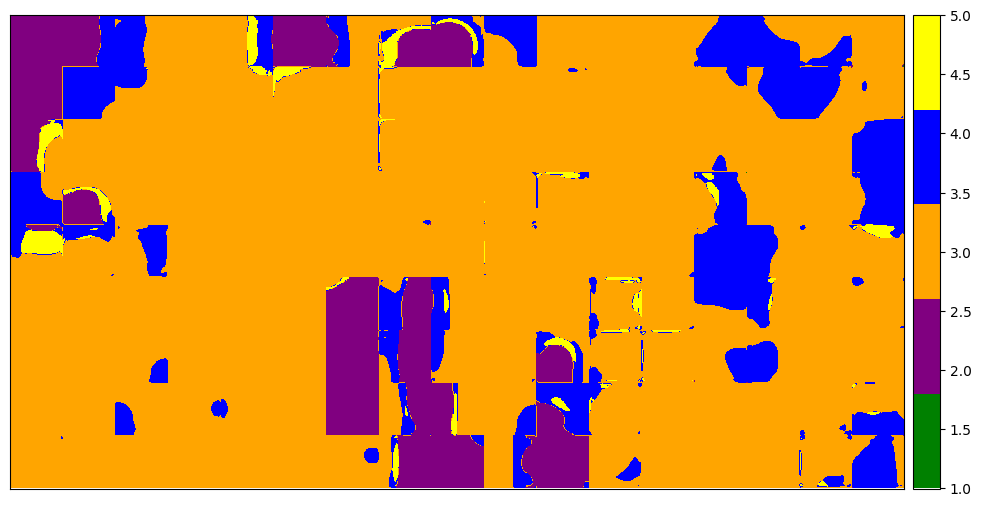

<Axes: >

In [121]:
from matplotlib.colors import ListedColormap
import earthpy.plot as ep

ep.plot_bands(resss_img[:,:,0],
              cmap=ListedColormap(['green', 'purple', 'orange', 'blue', 'yellow']))

In [122]:
categories_map

{'water': 1, 'forest': 2, 'fields': 3, 'city': 4, 'sands': 5, 'mountains': 6}

### TRY to use naive bayes

In [40]:
import layers.naive_bayes
importlib.reload(layers.naive_bayes)
# from keras.models import Model, save_model
# from keras.layers import Input

# Create the model
# model_new_1 = tf.keras.models.Sequential()
# model_new_1.add(tf.keras.models.InputLayer(shape=(12,)))  # Input layer
# model_new_1.add(layers.naive_bayes.MultiClassNaiveBayesLayer(num_features=12, num_of_categories=7))  # Naive Bayes layer
# model_new_1.add(tf.keras.models.Softmax())  #

model_new_gnb = tf.keras.models.Sequential([
    layers.naive_bayes.MultiClassNaiveBayesLayer(num_features=12, num_of_categories=6, input_shape=(12,)),
    Activation("softmax")
    ])

# Assuming you've trained or set the weights, you can then save the model:
#save_model(model, 'naive_bayes_model.h5')

In [33]:
model_new_gnb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','mse'])
model_new_gnb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multi_class_naive_bayes_la  (None, 6)                 144       
 yer (MultiClassNaiveBayesL                                      
 ayer)                                                           
                                                                 
 activation (Activation)     (None, 6)                 0         
                                                                 
Total params: 144 (576.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 144 (576.00 Byte)
_________________________________________________________________


In [29]:
x_tain_1 = []
y_train_1 = []

for x_d, y_d in train_dataset:
    x_tain_1.append(x_d.numpy())
    y_train_1.append((y_d.numpy()))

x_train_11 = np.concatenate(x_tain_1)
y_train_11 = np.concatenate(y_train_1)

In [30]:
y_train_11.shape

(2260, 64, 64, 7)

In [31]:
x_train_111 = x_train_11.reshape(x_train_11.shape[0]*x_train_11.shape[1]*x_train_11.shape[2],12)
y_train_111 = y_train_11.reshape(x_train_11.shape[0]*x_train_11.shape[1]*x_train_11.shape[2],7)

In [169]:
y_train_11

array([[[[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.]],

        [[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.]],

        [[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
    

In [175]:
y_train_111.shape

(9256960, 7)

In [163]:
#bayes_h = model_new_gnb.fit(x_train_111, y_train_111, epochs=1,batch_size=1024, validation_split=0.2)

7232/7232 [==============================] - 56s 8ms/step - loss: 1.9460 - accuracy: 0.0000e+00 - mse: 0.1224 - val_loss: 1.9459 - val_accuracy: 0.0000e+00 - val_mse: 0.1225


In [194]:
y_train_111.shape

(9256960, 7)

In [32]:
y_int_labels = np.argmax(y_train_111, axis=-1)
y_int_labels = y_int_labels-1
means = []
variances = []

num_classes = 6  # or however many you have

for i in range(num_classes):
    means.append(np.mean(x_train_111[y_int_labels == i], axis=0))
    variances.append(np.var(x_train_111[y_int_labels == i], axis=0))

means = np.array(means)
variances = np.array(variances)

In [33]:
x_tttt = x_ttt.reshape(x_ttt.shape[0]*x_ttt.shape[1]*x_ttt.shape[2],12)

NameError: name 'x_ttt' is not defined

In [225]:
means[0,:] = 0

In [226]:
variances[0,:] = 0

In [246]:
variances

array([[          nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan],
       [7.5072714e-04, 7.1359624e-04, 1.3902313e-03, 3.0582945e-03,
        3.5373361e-03, 1.4280407e-03, 1.3056325e-03, 1.2161554e-03,
        9.1588026e-04, 3.5124566e-04, 2.8814946e-04, 9.3785825e-04],
       [1.3390444e-05, 1.6815497e-05, 2.4349943e-05, 2.9035853e-05,
        5.9771624e-05, 3.3204668e-04, 6.1731291e-04, 7.5976737e-04,
        5.8099267e-04, 2.6931742e-04, 9.9144927e-05, 7.7060715e-04],
       [6.6382570e-05, 1.2958462e-04, 2.0797949e-04, 4.5792671e-04,
        4.7978957e-04, 7.9541467e-04, 1.0104702e-03, 1.1524193e-03,
        1.0566724e-03, 1.0603979e-03, 1.2097897e-03, 1.1417950e-03],
       [2.3635397e-04, 5.0459383e-04, 5.1512226e-04, 6.4966630e-04,
        4.8016667e-04, 7.2053948e-04, 9.7518112e-04, 1.3310516e-03,
        9.1753475e-04, 1.0548948e-03, 8.7359

In [239]:
means

array([[0.02915865, 0.03312196, 0.03894535, 0.03473867, 0.03876298,
        0.02387872, 0.02318608, 0.0209069 , 0.01605026, 0.01059942,
        0.00965033, 0.01814351],
       [0.01150276, 0.01467091, 0.02134492, 0.01352438, 0.03531998,
        0.10759359, 0.13688509, 0.14326456, 0.15282534, 0.07436027,
        0.03238188, 0.15238105],
       [0.0272764 , 0.03468506, 0.04632021, 0.05880858, 0.07405695,
        0.09216123, 0.10208715, 0.11047029, 0.1162836 , 0.15326554,
        0.12305496, 0.1156451 ],
       [0.03545165, 0.04030988, 0.04910934, 0.05284545, 0.06868093,
        0.09916554, 0.11136083, 0.11593673, 0.12217683, 0.12035356,
        0.09544441, 0.12089972],
       [0.09082571, 0.11970866, 0.17434332, 0.23805812, 0.26639113,
        0.27266017, 0.28622344, 0.29023218, 0.3006949 , 0.3668648 ,
        0.3540075 , 0.29408118],
       [0.03951728, 0.04714312, 0.06380208, 0.07952226, 0.09414418,
        0.10468826, 0.11244895, 0.12240051, 0.1254742 , 0.20080724,
        0.16093574,

In [197]:
model_new_gnb.layers

In [36]:
model_new_gnb.layers[0].set_weights([means, variances])

In [261]:
model_new_gnb.save("model_gnb.keras")

In [32]:
x_tests = []
y_tests = []

for xtest, ytest in test_dataset:
    x_tests.append(xtest.numpy())
    y_tests.append(ytest.numpy())

In [33]:
x_tests_1 = np.concatenate(x_tests)
y_tests_1 = np.concatenate(y_tests)

In [458]:
x_tests_1.shape

(18048, 64, 12)

In [44]:
nb_pred_res = model_new_gnb.predict(x_tttt, batch_size=2048)

4520/4520 [==============================] - 18s 4ms/step


In [46]:
y_tests_1.shape

(18048, 64, 7)

In [34]:
x_tests_1_vector = x_tests_1.reshape(x_tests_1.shape[0]*x_tests_1.shape[1],12)

In [35]:
y_tests_1_vector = y_tests_1.reshape(x_tests_1.shape[0]*x_tests_1.shape[1],7)

In [36]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve, precision_score, average_precision_score

In [50]:
nb_pred_res_core = model_new_gnb.predict(x_tests_1_vector, batch_size=2048)

564/564 [==============================] - 2s 4ms/step


In [51]:
nb_pred_res_core_categoriesed = tf.argmax(nb_pred_res_core,axis=-1).numpy()

In [37]:
y_tests_1_vector_categories = np.argmax(y_tests_1_vector, axis=-1)

In [38]:
y_tests_1_vector_categories = y_tests_1_vector_categories -1

In [69]:
dataset_values = []

for i in range(0,6):
    ll = len(y_tests_1_vector_categories[y_tests_1_vector_categories == i])
    print(f"Length of category {i} for real test dataset: {ll}")
    dataset_values.append(ll)

Length of category 0 for real test dataset: 356352
Length of category 1 for real test dataset: 167936
Length of category 2 for real test dataset: 344064
Length of category 3 for real test dataset: 114688
Length of category 4 for real test dataset: 167936
Length of category 5 for real test dataset: 4096


In [57]:
accuracy_score(nb_pred_res_core_categoriesed.flatten(), y_tests_1_vector_categories.flatten())

0.7930735053745568

In [70]:
gnb_values = []

for i in range(0,6):
    ll = len(nb_pred_res_core_categoriesed[nb_pred_res_core_categoriesed == i])
    print(f"Length of category {i} for nb prediction: {ll}")
    gnb_values.append(len(nb_pred_res_core_categoriesed[nb_pred_res_core_categoriesed == i]))

Length of category 0 for nb prediction: 315187
Length of category 1 for nb prediction: 169280
Length of category 2 for nb prediction: 262001
Length of category 3 for nb prediction: 171641
Length of category 4 for nb prediction: 156886
Length of category 5 for nb prediction: 80077


In [72]:
categories_values = []

for categorie, num in categories_map.items():
    categories_values.append(categorie)

In [73]:
categories_values

['water', 'forest', 'fields', 'city', 'sands', 'mountains']

In [58]:
classification_report(nb_pred_res_core_categoriesed.flatten(), y_tests_1_vector_categories.flatten())

'              precision    recall  f1-score   support\n\n           0       0.87      0.99      0.93    315187\n           1       0.94      0.94      0.94    169280\n           2       0.64      0.84      0.73    262001\n           3       0.63      0.42      0.50    171641\n           4       0.89      0.96      0.92    156886\n           5       0.86      0.04      0.08     80077\n\n    accuracy                           0.79   1155072\n   macro avg       0.81      0.70      0.68   1155072\nweighted avg       0.80      0.79      0.76   1155072\n'

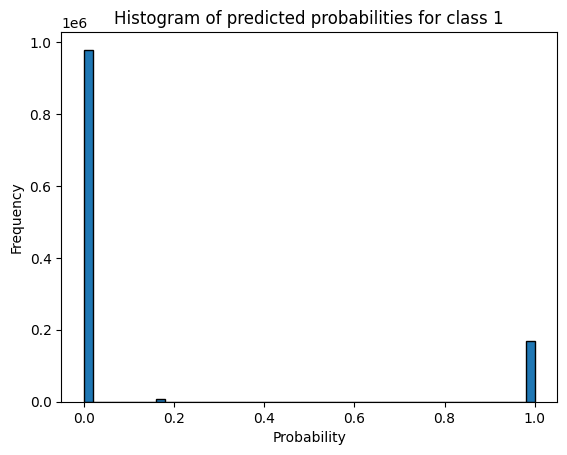

In [64]:
import matplotlib.pyplot as plt

plt.hist(nb_pred_res_core[:, 1], bins=50, edgecolor='k')
plt.title('Histogram of predicted probabilities for class 1')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

In [65]:
import dataset_tool.graph_utils

In [67]:
nb_hist_data = nb_pred_res_core + 1

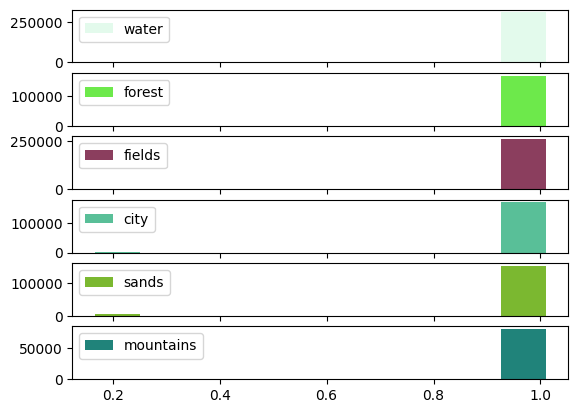

In [123]:
dataset_tool.graph_utils.createHistGraph(nb_pred_res_core, categories_map)

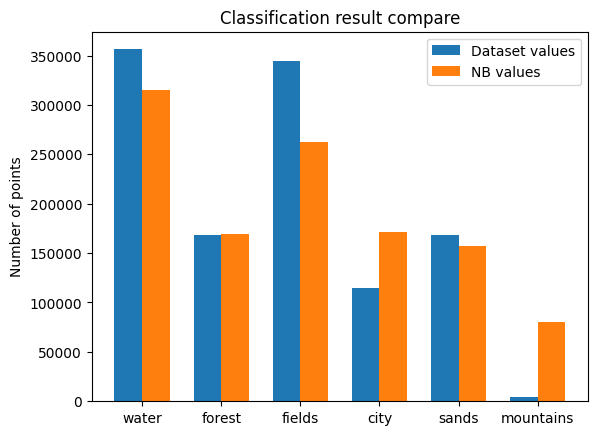

In [75]:
x = np.arange(len(categories_values))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dataset_values, width, label='Dataset values')
rects2 = ax.bar(x + width/2, gnb_values, width, label='NB values')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of points')
ax.set_title('Classification result compare')
ax.set_xticks(x)
ax.set_xticklabels(categories_values)
ax.legend()

In [59]:
gnb_eval = model_new_gnb.evaluate(nb_pred_res_core, y_tests_1)

ValueError: Data cardinality is ambiguous:
  x sizes: 1155072
  y sizes: 18048
Make sure all arrays contain the same number of samples.

/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


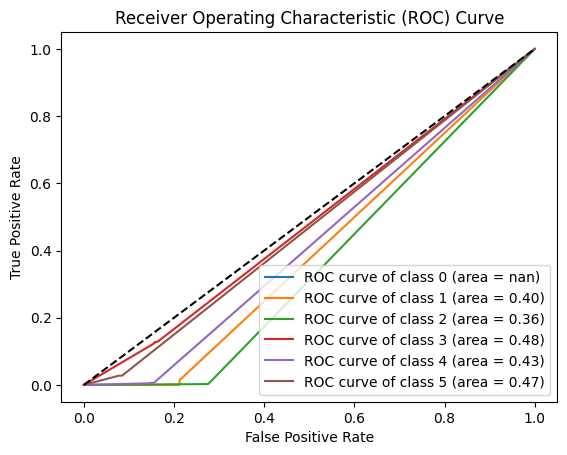

In [125]:
n_classes = nb_pred_res_core.shape[1]

# Для ROC
plt.figure()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_tests_1_vector[:, i], nb_pred_res_core[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve of class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


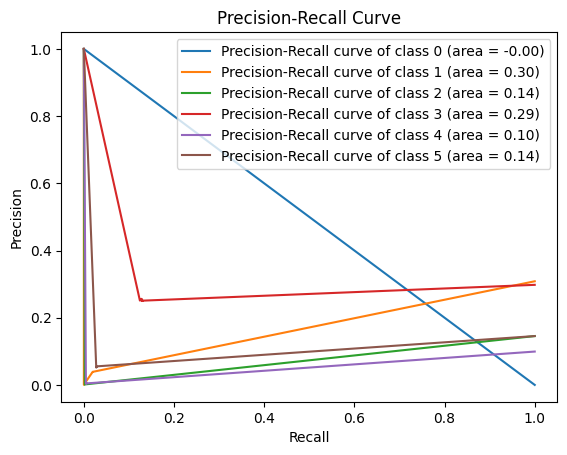

In [127]:
# Для Precision-Recall
plt.figure()
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_tests_1_vector[:, i], nb_pred_res_core[:, i])
    average_precision = average_precision_score(y_tests_1_vector[:, i], nb_pred_res_core[:, i])
    plt.plot(recall, precision, label=f'Precision-Recall curve of class {i} (area = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

In [241]:
nb_pres_res_1 = tf.argmax(nb_pred_res,axis=-1).numpy()

In [242]:
nb_pres_res_1.max()

5

In [248]:
y_testtt = y_tttt - 1

In [244]:
y_tttt.shape

(9256960,)

In [250]:
test_imgs_array.shape

(12, 638, 1094)

In [61]:
test_arr_nb = test_imgs_array/x_data_cubes.max()

In [62]:
test_arr_nb = np.moveaxis(test_arr_nb, 0, 2)

In [63]:
test_arr_nb.shape

(733, 1250, 12)

In [64]:
test_arr_to_pred = test_arr_nb.reshape(test_arr_nb.shape[0]*test_arr_nb.shape[1],12)

In [82]:
test_arr_nb_pred_res = model_new_gnb.predict(test_arr_to_pred,batch_size=2048)

448/448 [==============================] - 2s 4ms/step


In [83]:
test_arr_nb_pred = tf.argmax(test_arr_nb_pred_res, axis=-1)

In [100]:
test_arr_nb_pred_ss = test_arr_nb_pred.numpy().reshape(733,1250)

In [102]:
test_arr_nb_pred_ss.max()

5

In [103]:
test_arr_nb_pred_ss = test_arr_nb_pred_ss + 1

In [104]:
test_arr_nb_pred_ss [test_arr_nb_pred_ss == 6] = 3

In [89]:
categoreis_map_inverted = {v: k for k, v in categories_map.items()}

In [107]:
test_arr_nb_pred_ss.min()

1

In [108]:
categoreis_map_inverted.keys()

dict_keys([1, 2, 3, 4, 5, 6])

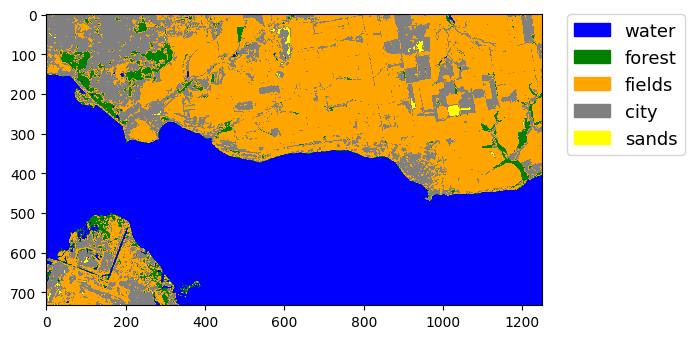

In [122]:
from matplotlib.colors import ListedColormap
import earthpy.plot as ep

# im = ep.plot_bands(test_arr_nb_pred_ss,
#                    vmin=1, vmax=6,
#               cmap=ListedColormap(['green', 'purple', 'orange', 'blue', 'yellow','red']))
#ep.make_col_list()
im = plt.imshow(test_arr_nb_pred_ss,
           vmin=1,vmax=6,
               cmap=ListedColormap(['blue', 'green', 'orange', 'grey', 'yellow','brown']))
ep.draw_legend(im_ax = im, titles = ["water","forest","fields","city","sands"])
# leg_neg = ep.draw_legend(im_ax = im, titles = categoreis_map_inverted.values())
#plt.show()
#im.legend(list(categoreis_map_inverted.values()))
# cbar = plt.colorbar(fraction=0.046, pad=0.04)
# #
# cbar.set_ticks(list(categoreis_map_inverted.keys()))
# cbar.set_ticklabels(list(categoreis_map_inverted.values()))

plt.show()

In [262]:
categories_map

{'water': 1, 'forest': 2, 'fields': 3, 'city': 4, 'sands': 5, 'mountains': 6}

### Test KNNC

In [293]:
y_train_111.shape

(9256960, 7)

In [41]:
import layers.knnc
importlib.reload(layers.knnc)
# model_new_knn = tf.keras.models.Sequential([
#     layers.knnc.KNNLayer(k=3, num_classes=6,input_shape=(12,)),
#     Activation("softmax")
#     ])

# Sample usage

model_knnc = tf.keras.models.Sequential([
    layers.knnc.KNNClassifierLayer2(k=3,X_train = x_train_111, y_train = y_int_labels, input_shape=(12,)),
    Activation("softmax")
])

# Assuming you've trained or set the weights, you can then save the model:
#save_model(model, 'naive_bayes_model.h5')

KeyboardInterrupt: 

In [62]:
importlib.reload(layers.knnc)

<module 'layers.knnc' from '/mnt/d/aspiranture/Satellite_Imagery_Analysis/Classification/layers/knnc.py'>

In [35]:
model_knnc.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','mse'])
model_knnc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 knn_classifier_layer2 (KNN  (None, 6)                 0         
 ClassifierLayer2)                                               
                                                                 
 activation (Activation)     (None, 6)                 0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_knnc.save("kncc.h5", save_format='h5')

/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
predictions_knnc = model_knnc.predict(test_arr_to_pred, batch_size=512)

   1/1364 [..............................] - ETA: 3:29

2023-09-24 21:18:12.386453: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } attr { key: "_has_manual_control_dependencies" value { b: true } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1740 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 22842179584 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1364/1364 [==============================] - 166s 122ms/step


In [70]:
predictions_knnc.shape

(697972, 6)

NameError: name 'test_arr_knn_pred_ss' is not defined

In [2]:
test_arr_knn_pred = tf.argmax(predictions_knnc, axis=-1)
test_arr_knn_pred_ss = test_arr_knn_pred.numpy().reshape(638, 1094)
from matplotlib.colors import ListedColormap
import earthpy.plot as ep

test_arr_knn_pred_ss = test_arr_knn_pred_ss + 1

ep.plot_bands(test_arr_knn_pred_ss,
              cmap=ListedColormap(['green', 'purple', 'orange', 'blue', 'yellow']))

NameError: name 'tf' is not defined

# Binary tree method

## Naive bayes

### Water - no-water

In [459]:
from sklearn.model_selection import train_test_split

In [460]:
x_data_stadartized.shape

(2825, 64, 64, 12)

In [461]:
x_data_stadartized_vec = x_data_stadartized.reshape(x_data_stadartized.shape[0]*x_data_stadartized.shape[1]*x_data_stadartized.shape[2],12)

In [462]:
y_data_cubes.shape

(2825, 64, 64)

In [463]:
y_data_cubes_vec = y_data_cubes.reshape(y_data_cubes.shape[0]*y_data_cubes.shape[1]*y_data_cubes.shape[2])

In [475]:
y_data_cubes_vec.min()

1

In [479]:
x_binary_cl_train,x_binary_cl_test, y_binary_cl_train, y_binary_cl_test = train_test_split(x_data_stadartized_vec, y_data_cubes_vec, test_size=0.15, stratify=y_data_cubes_vec)

In [480]:
y_binary_cl_train.max()

6

In [465]:
model_new_gnb_binary_1 = tf.keras.models.Sequential([
    layers.naive_bayes.MultiClassNaiveBayesLayer(num_features=12, num_of_categories=2, input_shape=(12,)),
    Activation("softmax")
])

# Assuming you've trained or set the weights, you can then save the model:
#save_model(model, 'naive_bayes_model.h5')
model_new_gnb_binary_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
model_new_gnb_binary_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multi_class_naive_bayes_la  (None, 2)                 48        
 yer_7 (MultiClassNaiveBaye                                      
 sLayer)                                                         
                                                                 
 activation_7 (Activation)   (None, 2)                 0         
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 48 (192.00 Byte)
_________________________________________________________________


In [42]:
categories_map

{'water': 1, 'forest': 2, 'fields': 3, 'city': 4, 'sands': 5, 'mountains': 6}

In [452]:
y_int_labels_1 = np.argmax(y_train_111, axis=-1)

In [457]:
len(y_int_labels_1[y_int_labels_1 == 3])

1445888

In [ ]:
y_train_111

In [44]:
y_int_labels_1.max()

6

In [45]:
y_int_labels_1[y_int_labels_1 != 1] = 2

In [46]:
y_int_labels_1.max()

2

In [47]:
y_int_labels_1 = y_int_labels_1-1

In [48]:
y_int_labels_1.max()

1

In [437]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# x_resampled_1, y_resampled_1 = sm.fit_resample(x_train_111, y_int_labels_1)

In [451]:
len(y_int_labels_1[y_int_labels_1 == 0])-len(y_int_labels_1[y_int_labels_1 == 1])

2564096

In [481]:
x_binary_train_0 = x_binary_cl_train.copy()
y_binary_train_0 = y_binary_cl_train.copy()

In [482]:
y_binary_train_0 = y_binary_train_0 - 1

In [485]:
y_binary_train_0[y_binary_train_0!=0]= 1

In [486]:
means_1 = []
variances_1 = []

num_classes = 2  # or however many you have

for i in range(num_classes):
    means_1.append(np.mean(x_binary_train_0[y_binary_train_0 == i], axis=0))
    variances_1.append(np.var(x_binary_train_0[y_binary_train_0 == i], axis=0))

means_1 = np.array(means_1)
variances_1 = np.array(variances_1)

In [50]:
means_1

array([[0.02933434, 0.03338125, 0.03916715, 0.03483061, 0.03903008,
        0.02419031, 0.02348292, 0.0212318 , 0.01637849, 0.01084627,
        0.00987053, 0.01845756],
       [0.02788477, 0.03564478, 0.04901504, 0.05831729, 0.07696233,
        0.11539255, 0.133244  , 0.14025955, 0.14743847, 0.14113662,
        0.10868028, 0.14656533]], dtype=float32)

In [487]:
model_new_gnb_binary_1.layers[0].set_weights([means_1, variances_1])

In [488]:
nb_pred_res_core_binary_1 = model_new_gnb_binary_1.predict(x_binary_cl_test, batch_size=2048)

848/848 [==============================] - 3s 3ms/step


In [489]:
nb_pred_res_core_binary_1_cateries = tf.argmax(nb_pred_res_core_binary_1, axis=-1).numpy()

In [442]:
print(f"Num of water is {len(nb_pred_res_core_binary_1_cateries[nb_pred_res_core_binary_1_cateries == 0])}")

Num of water is 502363


In [490]:
y_tests_1_vector_categories_1 = y_binary_cl_test.copy()

In [492]:
y_tests_1_vector_categories_1 = y_tests_1_vector_categories_1 - 1

In [493]:
y_tests_1_vector_categories_1[y_tests_1_vector_categories_1 != 0] = 1

In [494]:
y_tests_1_vector_categories_1.max()

1

In [495]:
accuracy_score(nb_pred_res_core_binary_1_cateries.flatten(), y_tests_1_vector_categories_1.flatten())

0.9275229304941003

In [496]:
nb_binary_pic_1 = model_new_gnb_binary_1.predict(test_arr_to_pred, batch_size=2048)

448/448 [==============================] - 2s 3ms/step


In [497]:
nb_binary_pic_1_cat = tf.argmax(nb_binary_pic_1, axis=-1).numpy()

In [498]:
nb_binary_pic_1_cat.max()

1

In [499]:
nb_binary_pic_1_pic = nb_binary_pic_1_cat.reshape(733,1250)

In [500]:
nb_binary_pic_1_pic = nb_binary_pic_1_pic +1

In [501]:
nb_binary_pic_1_pic.max()

2

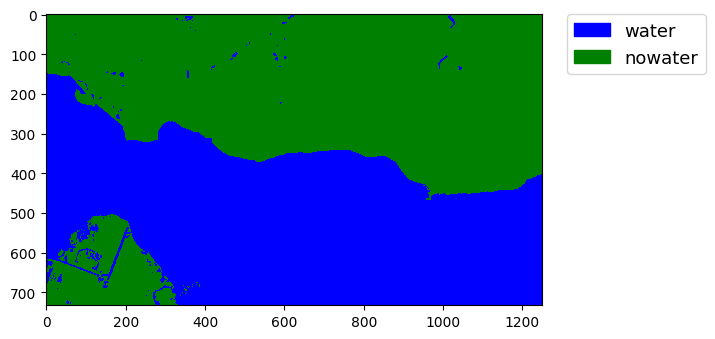

In [502]:
from matplotlib.colors import ListedColormap
import earthpy.plot as ep
import matplotlib.pyplot as plt

# im = ep.plot_bands(nb_binary_pic_1_pic,
#                    vmin=1, vmax=6,
#               cmap=ListedColormap(['green', 'purple', 'orange', 'blue', 'yellow','red']))
#ep.make_col_list()
im = plt.imshow(nb_binary_pic_1_pic,
           vmin=1,vmax=6,
               cmap=ListedColormap(['blue', 'green', 'orange', 'grey', 'yellow','brown']))
ep.draw_legend(im_ax = im, titles = ["water","nowater"])
#leg_neg = ep.draw_legend(im_ax = im, titles = categoreis_map_inverted.values())
#plt.show()
#im.legend(list(categoreis_map_inverted.values()))
# cbar = plt.colorbar(fraction=0.046, pad=0.04)
# #
# cbar.set_ticks(list(categoreis_map_inverted.keys()))
# cbar.set_ticklabels(list(categoreis_map_inverted.values()))

# plt.show()

In [503]:
model_new_gnb_binary_1.save("nb_binary_water_nowater_2.keras")

### Forest non-Forest

In [504]:
model_new_gnb_binary_2 = tf.keras.models.Sequential([
    layers.naive_bayes.MultiClassNaiveBayesLayer(num_features=12, num_of_categories=2, input_shape=(12,)),
    Activation("softmax")
])

# Assuming you've trained or set the weights, you can then save the model:
#save_model(model, 'naive_bayes_model.h5')
model_new_gnb_binary_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
model_new_gnb_binary_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multi_class_naive_bayes_la  (None, 2)                 48        
 yer_8 (MultiClassNaiveBaye                                      
 sLayer)                                                         
                                                                 
 activation_8 (Activation)   (None, 2)                 0         
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 48 (192.00 Byte)
_________________________________________________________________


In [505]:
y_train_2 = y_binary_cl_train.copy()

In [507]:
y_water_idx = np.where(y_train_2 == 1)[0]

In [508]:
x_train_2 = np.delete(x_binary_cl_train, y_water_idx, axis=0)

In [509]:
y_train_2.min()

1

In [510]:
y_train_2_labels = np.delete(y_train_2, y_water_idx)

In [511]:
y_train_2_labels[y_train_2_labels == 2] = 0

In [512]:
y_train_2_labels[y_train_2_labels != 0] = 1

In [513]:
means_2 = []
variances_2 = []

num_classes = 2  # or however many you have

for i in range(num_classes):
    means_2.append(np.mean(x_train_2[y_train_2_labels == i], axis=0))
    variances_2.append(np.var(x_train_2[y_train_2_labels == i], axis=0))

means_2 = np.array(means_2)
variances_2 = np.array(variances_2)

In [514]:
model_new_gnb_binary_2.layers[0].set_weights([means_2, variances_2])

In [544]:
y_binary_cl_test_2 = y_binary_cl_test.copy()

In [517]:
y_water_idx_tests = np.where(y_binary_cl_test_2 == 1)[0]

In [540]:
x_tests_2_vector = np.delete(x_binary_cl_test, y_water_idx_tests, axis=0)

In [541]:
nb_pred_res_core_binary_2 = model_new_gnb_binary_2.predict(x_tests_2_vector, batch_size=2048)

365/365 [==============================] - 1s 3ms/step


In [542]:
nb_pred_res_core_binary_2_vector = tf.argmax(nb_pred_res_core_binary_2, axis=-1).numpy()

In [543]:
nb_pred_res_core_binary_2_vector.min()

0

In [536]:
#y_tests_1_vector_categories_2_replaced = y_tests_1_vector_categories_2_replaced - 1

In [546]:
y_binary_cl_test_2 = np.delete(y_binary_cl_test, y_water_idx_tests,axis=0)

In [548]:
y_binary_cl_test_2[y_binary_cl_test_2 == 2] = 0

In [549]:
y_binary_cl_test_2[y_binary_cl_test_2 != 0] = 1

In [550]:
accuracy_score(nb_pred_res_core_binary_2_vector, y_binary_cl_test_2)

0.9675872342249657

In [551]:
classification_report(nb_pred_res_core_binary_2_vector, y_binary_cl_test_2)

'              precision    recall  f1-score   support\n\n           0       0.96      0.93      0.95    236728\n           1       0.97      0.98      0.98    509768\n\n    accuracy                           0.97    746496\n   macro avg       0.97      0.96      0.96    746496\nweighted avg       0.97      0.97      0.97    746496\n'

In [552]:
pic_water_idxs = np.where(nb_binary_pic_1_cat == 0)[0]

In [553]:
nb_binary_pic_1_cat.max()

1

In [554]:
pic_without_water = np.delete(test_arr_to_pred, pic_water_idxs, axis=0)

In [555]:
pic_forest_nonforest_pred = model_new_gnb_binary_2.predict(pic_without_water, batch_size=2048)

236/236 [==============================] - 1s 3ms/step


In [556]:
pic_forest_nonforest_pred_vector = tf.argmax(pic_forest_nonforest_pred, axis=-1).numpy()

In [557]:
pic_forest_nonforest_pred_vector.max()

1

In [558]:
pic_forest_nonforest_pred_vector_tocombine = pic_forest_nonforest_pred_vector.copy()

In [559]:
pic_forest_nonforest_pred_vector_tocombine = pic_forest_nonforest_pred_vector_tocombine + 1

In [560]:
nb_binary_pic_1_cat.shape[0]

916250

In [561]:
combined_vec = np.empty(nb_binary_pic_1_cat.shape[0], dtype=int)

In [562]:
combined_vec[pic_water_idxs] = 0

In [563]:
other_idxs = np.setdiff1d(np.arange(nb_binary_pic_1_cat.shape[0]), pic_water_idxs)

In [564]:
combined_vec[other_idxs] = pic_forest_nonforest_pred_vector_tocombine

In [565]:
combined_vec = combined_vec + 1

In [566]:
combined_pic_1 = combined_vec.reshape(733,1250)

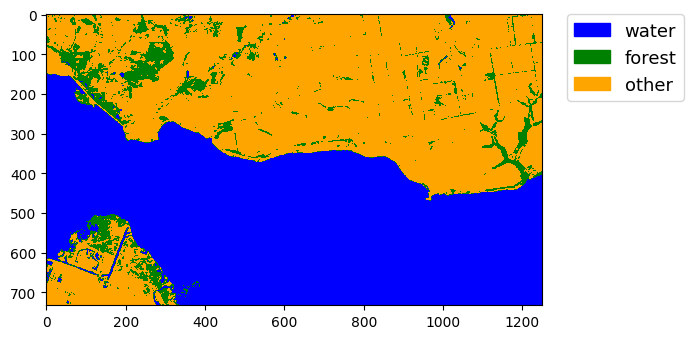

In [567]:
from matplotlib.colors import ListedColormap
import earthpy.plot as ep
import matplotlib.pyplot as plt

# im = ep.plot_bands(nb_binary_pic_1_pic,
#                    vmin=1, vmax=6,
#               cmap=ListedColormap(['green', 'purple', 'orange', 'blue', 'yellow','red']))
#ep.make_col_list()
im = plt.imshow(combined_pic_1,
           vmin=1,vmax=6,
               cmap=ListedColormap(['blue', 'green', 'orange', 'grey', 'yellow','brown']))
ep.draw_legend(im_ax = im, titles = ["water","forest", "other"])

In [568]:
y_tests_1_vector_categories_water_forest = y_tests_1_vector_categories.copy()

### Fields non-fiedls

In [154]:
y_train_2_labels.max()

1

In [155]:
# y_train_forests_idx = np.where(y_train_2_labels == 0)[0]

In [578]:
y_int_labels_3 = y_binary_cl_train.copy()

In [579]:
y_traint_forest_idx = np.where(y_int_labels_3 == 2)[0]

In [580]:
index_to_exclude_train_3 = np.concatenate([y_water_idx, y_traint_forest_idx])

In [581]:
x_train_3 = np.delete(x_binary_cl_train, index_to_exclude_train_3, axis=0)

In [582]:
y_train_3 = np.delete(y_binary_cl_train, index_to_exclude_train_3, axis=0)

In [583]:
y_train_3_cat = y_train_3

In [584]:
y_train_3_cat.min()

3

In [585]:
y_train_3_cat[y_train_3_cat == 3] = 0
y_train_3_cat[y_train_3_cat != 0] = 1

In [586]:
model_new_gnb_binary_3 = tf.keras.models.Sequential([
    layers.naive_bayes.MultiClassNaiveBayesLayer(num_features=12, num_of_categories=2, input_shape=(12,)),
    Activation("softmax")
])

# Assuming you've trained or set the weights, you can then save the model:
#save_model(model, 'naive_bayes_model.h5')
model_new_gnb_binary_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
model_new_gnb_binary_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multi_class_naive_bayes_la  (None, 2)                 48        
 yer_9 (MultiClassNaiveBaye                                      
 sLayer)                                                         
                                                                 
 activation_9 (Activation)   (None, 2)                 0         
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 48 (192.00 Byte)
_________________________________________________________________


In [587]:
means_3 = []
variances_3 = []

num_classes = 2  # or however many you have

for i in range(num_classes):
    means_3.append(np.mean(x_train_3[y_train_3_cat == i], axis=0))
    variances_3.append(np.var(x_train_3[y_train_3_cat == i], axis=0))

means_3 = np.array(means_3)
variances_3 = np.array(variances_3)

In [588]:
model_new_gnb_binary_3.layers[0].set_weights([means_3, variances_3])

In [589]:
y_test_forest_idx = np.where(y_binary_cl_test == 2)[0]

In [590]:
y_test_exclude_idx_3 = np.concatenate([y_water_idx_tests, y_test_forest_idx])

In [591]:
x_test_3 = np.delete(x_binary_cl_test, y_test_exclude_idx_3, axis=0)

In [592]:
x_test_3.shape

(516710, 12)

In [593]:
y_test_3 = np.delete(y_binary_cl_test, y_test_exclude_idx_3, axis=0)

In [594]:
test_3_pred = model_new_gnb_binary_3.predict(x_test_3, batch_size=2048)

253/253 [==============================] - 1s 3ms/step


In [595]:
test_3_pred_cat = tf.argmax(test_3_pred, axis=-1).numpy()

In [597]:
y_test_3.min()

3

In [598]:
y_test_3[y_test_3 == 3] = 0
y_test_3[y_test_3 != 0] = 1


In [599]:
accuracy_score(test_3_pred_cat, y_test_3)

0.7858508641210737

In [600]:
pic_forest_idxs = np.where(combined_vec == 2)[0]

In [601]:
pic_idx_to_exclude_3 = np.concatenate([pic_forest_idxs, pic_water_idxs])

In [602]:
pic_excluded_3 = np.delete(test_arr_to_pred, pic_idx_to_exclude_3, axis=0)

In [603]:
pic_prediction_3 = model_new_gnb_binary_3.predict(pic_excluded_3, batch_size=2048)

212/212 [==============================] - 1s 3ms/step


In [604]:
pic_prediction_3_cat = tf.argmax(pic_prediction_3, axis=-1).numpy()

In [605]:
pic_prediction_3_cat = pic_prediction_3_cat + 2

In [606]:
combined_vec_3 = np.empty(nb_binary_pic_1_cat.shape[0], dtype=int)

In [607]:
combined_vec_3[pic_water_idxs] = 0

In [608]:
combined_vec_3[pic_forest_idxs] = 1

In [609]:
other_idxs_3 = np.setdiff1d(np.arange(nb_binary_pic_1_cat.shape[0]), pic_idx_to_exclude_3)

In [610]:
combined_vec_3[other_idxs_3] = pic_prediction_3_cat

In [611]:
combined_vec_3 = combined_vec_3 + 1

In [612]:
combined_vec_3_pic = combined_vec_3.reshape(733,1250)

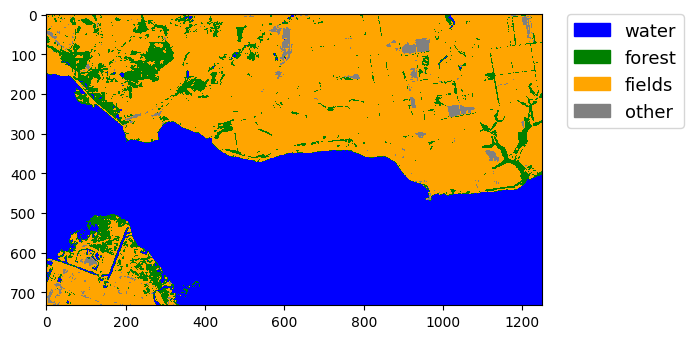

In [613]:
from matplotlib.colors import ListedColormap
import earthpy.plot as ep
import matplotlib.pyplot as plt

# im = ep.plot_bands(nb_binary_pic_1_pic,
#                    vmin=1, vmax=6,
#               cmap=ListedColormap(['green', 'purple', 'orange', 'blue', 'yellow','red']))
#ep.make_col_list()
im = plt.imshow(combined_vec_3_pic,
           vmin=1,vmax=6,
               cmap=ListedColormap(['blue', 'green', 'orange', 'grey', 'yellow','brown']))
ep.draw_legend(im_ax = im, titles = ["water","forest", "fields", "other"])

### City non-city

In [614]:
y_int_labels_4 = np.argmax(y_binary_cl_train, axis=-1)
y_traint_fields_idx = np.where(y_int_labels_4 == 3)[0]

/tmp/ipykernel_1299/2175753725.py:2: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  y_traint_fields_idx = np.where(y_int_labels_4 == 3)[0]


In [615]:
index_to_exclude_train_4 = np.concatenate([y_traint_fields_idx, index_to_exclude_train_3])
x_train_4 = np.delete(x_binary_cl_train, index_to_exclude_train_4, axis=0)
y_train_4 = np.delete(y_binary_cl_train, index_to_exclude_train_4, axis=0)
#y_train_4_cat = np.argmax(y_train_4, axis=-1)
y_train_4.max()

6

In [616]:
y_train_4[y_train_4 == 4] = 0
y_train_4[y_train_4 != 0] = 1

In [617]:
model_new_gnb_binary_4 = tf.keras.models.Sequential([
    layers.naive_bayes.MultiClassNaiveBayesLayer(num_features=12, num_of_categories=2, input_shape=(12,)),
    Activation("softmax")
])

# Assuming you've trained or set the weights, you can then save the model:
#save_model(model, 'naive_bayes_model.h5')
model_new_gnb_binary_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
model_new_gnb_binary_4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multi_class_naive_bayes_la  (None, 2)                 48        
 yer_10 (MultiClassNaiveBay                                      
 esLayer)                                                        
                                                                 
 activation_10 (Activation)  (None, 2)                 0         
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 48 (192.00 Byte)
_________________________________________________________________


In [618]:
means_4 = []
variances_4 = []

num_classes = 2  # or however many you have

for i in range(num_classes):
    means_4.append(np.mean(x_train_4[y_train_4 == i], axis=0))
    variances_4.append(np.var(x_train_4[y_train_4 == i], axis=0))

means_4 = np.array(means_4)
variances_4 = np.array(variances_4)


In [619]:
model_new_gnb_binary_4.layers[0].set_weights([means_4, variances_4])

In [620]:
y_test_fields_idx = np.where(y_binary_cl_test == 3)[0]
y_test_exclude_idx_4 = np.concatenate([y_water_idx_tests, y_test_forest_idx, y_test_fields_idx])
x_test_4 = np.delete(x_binary_cl_test, y_test_exclude_idx_4, axis=0)
x_test_4.shape
y_test_4 = np.delete(y_binary_cl_test, y_test_exclude_idx_4, axis=0)

In [621]:
test_4_pred = model_new_gnb_binary_4.predict(x_test_4, batch_size=2048)

99/99 [==============================] - 0s 4ms/step


In [622]:
test_4_pred_cat = tf.argmax(test_4_pred, axis=-1).numpy()

In [623]:
y_test_4[y_test_4 == 4] = 0
y_test_4[y_test_4 != 0] = 1

In [624]:
accuracy_score(test_4_pred_cat, y_test_4)

0.8942449922577262

In [625]:
pic_fields_idxs = np.where(combined_vec_3 == 3)[0]
pic_idx_to_exclude_4 = np.concatenate([pic_idx_to_exclude_3, pic_fields_idxs])
pic_excluded_4 = np.delete(test_arr_to_pred, pic_idx_to_exclude_4, axis=0)

In [626]:
pic_excluded_4.shape

(15340, 12)

In [627]:
pic_prediction_4 = model_new_gnb_binary_4.predict(pic_excluded_4, batch_size=2048)

8/8 [==============================] - 0s 3ms/step


In [628]:
pic_prediction_4_cat = tf.argmax(pic_prediction_4, axis=-1).numpy()
pic_prediction_4_cat = pic_prediction_4_cat + 3

In [629]:
len(pic_prediction_4_cat == 4)

15340

In [630]:
pic_prediction_4_cat.max()

4

In [631]:
combined_vec_4 = np.empty(nb_binary_pic_1_cat.shape[0], dtype=int)
combined_vec_4[pic_water_idxs] = 0
combined_vec_4[pic_forest_idxs] = 1
combined_vec_4[pic_fields_idxs] = 2

In [632]:
other_idxs_4 = np.setdiff1d(np.arange(nb_binary_pic_1_cat.shape[0]), pic_idx_to_exclude_4)

In [633]:
combined_vec_4[other_idxs_4] = pic_prediction_4_cat

In [634]:
combined_vec_4 = combined_vec_4 + 1

In [635]:
combined_vec_4_pic = combined_vec_4.reshape(733,1250)

In [636]:
combined_vec_4_pic.max()

5

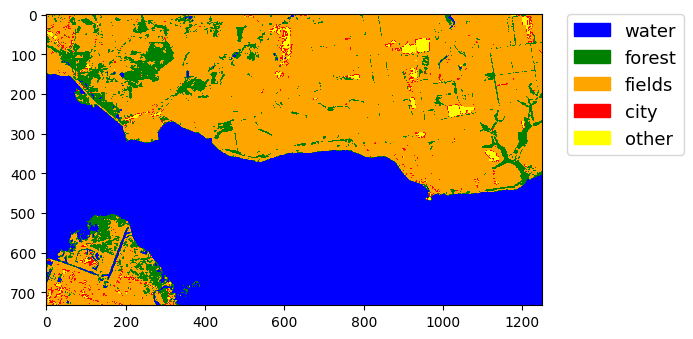

In [637]:
from matplotlib.colors import ListedColormap
import earthpy.plot as ep
import matplotlib.pyplot as plt

# im = ep.plot_bands(nb_binary_pic_1_pic,
#                    vmin=1, vmax=6,
#               cmap=ListedColormap(['green', 'purple', 'orange', 'blue', 'yellow','red']))
#ep.make_col_list()
im = plt.imshow(combined_vec_4_pic,
           vmin=1,vmax=6,
               cmap=ListedColormap(['blue', 'green', 'orange', 'red', 'yellow','brown']))
ep.draw_legend(im_ax = im, titles = ["water","forest", "fields", "city", "other"])

### Sands non-Sands

In [638]:
y_int_labels_5 = np.argmax(y_binary_cl_train, axis=-1)
y_traint_cities_idx = np.where(y_int_labels_5 == 4)[0]

/tmp/ipykernel_1299/4130145142.py:2: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  y_traint_cities_idx = np.where(y_int_labels_5 == 4)[0]


In [639]:
index_to_exclude_train_5 = np.concatenate([y_traint_cities_idx, index_to_exclude_train_4])
x_train_5 = np.delete(x_binary_cl_train, index_to_exclude_train_5, axis=0)
y_train_5 = np.delete(y_binary_cl_train, index_to_exclude_train_5, axis=0)

In [640]:
y_train_5[y_train_5 == 5] = 0
y_train_5[y_train_5 != 0] = 1

In [641]:
model_new_gnb_binary_5 = tf.keras.models.Sequential([
    layers.naive_bayes.MultiClassNaiveBayesLayer(num_features=12, num_of_categories=2, input_shape=(12,)),
    Activation("softmax")
])

# Assuming you've trained or set the weights, you can then save the model:
#save_model(model, 'naive_bayes_model.h5')
model_new_gnb_binary_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
model_new_gnb_binary_5.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multi_class_naive_bayes_la  (None, 2)                 48        
 yer_11 (MultiClassNaiveBay                                      
 esLayer)                                                        
                                                                 
 activation_11 (Activation)  (None, 2)                 0         
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 48 (192.00 Byte)
_________________________________________________________________


In [642]:
means_5 = []
variances_5 = []

num_classes = 2  # or however many you have

for i in range(num_classes):
    means_5.append(np.mean(x_train_5[y_train_5 == i], axis=0))
    variances_5.append(np.var(x_train_5[y_train_5 == i], axis=0))

means_5 = np.array(means_5)
variances_5 = np.array(variances_5)

In [643]:
model_new_gnb_binary_5.layers[0].set_weights([means_5, variances_5])

In [644]:
y_test_cities_idx = np.where(y_binary_cl_test == 4)[0]
y_test_exclude_idx_5 = np.concatenate([y_water_idx_tests, y_test_forest_idx, y_test_fields_idx, y_test_cities_idx])
x_test_5 = np.delete(x_binary_cl_test, y_test_exclude_idx_5, axis=0)
x_test_5.shape
y_test_5 = np.delete(y_binary_cl_test, y_test_exclude_idx_5, axis=0)

In [645]:
test_5_pred = model_new_gnb_binary_5.predict(x_test_5, batch_size=2048)

57/57 [==============================] - 0s 4ms/step


In [646]:
test_5_pred_cat = tf.argmax(test_5_pred, axis=-1).numpy()

In [647]:
y_test_5[y_test_5 == 5] = 0
y_test_5[y_test_5 != 0] = 1

In [648]:
accuracy_score(test_5_pred_cat, y_test_5)

0.8697565470500599

In [649]:
y_test_full_array = np.empty(y_tests_1_vector_categories.shape[0], dtype=int)

#### Check data accuray by steps

##### 1. Water - non-water

In [407]:
accuracy_score(nb_pred_res_core_binary_1_cateries.flatten(), y_tests_1_vector_categories_1.flatten())

0.8540549853169326

##### 2. Forest - non-forest

In [650]:
y_water_idx_predicted_0 = np.where(nb_pred_res_core_binary_1_cateries == 0)[0]

In [651]:
x_tests_2_vector = np.delete(x_binary_cl_test, y_water_idx_predicted_0, axis=0)

In [672]:
y_tests_1_vector_categories_2 = y_binary_cl_test.copy()

In [673]:
#y_tests_1_vector_categories_2 = np.delete(y_tests_1_vector_categories_2, y_water_idx_predicted_0, axis=0)

In [674]:
nb_tests_predict_2 = model_new_gnb_binary_2.predict(x_tests_2_vector, batch_size=2048)

356/356 [==============================] - 1s 3ms/step


In [675]:
nb_tests_predict_2_cat = tf.argmax(nb_tests_predict_2, axis=-1).numpy()

In [677]:
y_tests_1_vector_categories_2.max()

6

In [678]:
y_tests_1_vector_categories_2[y_tests_1_vector_categories_2 == 3] = 3
y_tests_1_vector_categories_2[y_tests_1_vector_categories_2 == 4] = 3
y_tests_1_vector_categories_2[y_tests_1_vector_categories_2 == 5] = 3


In [679]:
y_pred_2_combined = np.empty(x_binary_cl_test.shape[0], dtype=int)

In [680]:
y_pred_2_combined[y_water_idx_predicted_0] = 1

In [681]:
y_pred_2_other_idx = np.setdiff1d(np.arange(x_binary_cl_test.shape[0]), y_water_idx_predicted_0)

In [682]:
nb_tests_predict_2_cat = nb_tests_predict_2_cat + 1 + 1

In [683]:
y_pred_2_combined[y_pred_2_other_idx] = nb_tests_predict_2_cat

In [684]:
accuracy_score(y_pred_2_combined, y_tests_1_vector_categories_2)

0.9116645925516225

##### 3. Field - non-field

In [685]:
y_forest_idx_predicted_0 = np.where(y_pred_2_combined == 2)[0]

In [686]:
x_tests_3_exclude = np.concatenate([y_forest_idx_predicted_0, y_water_idx_predicted_0])

In [687]:
x_tests_3_vector = np.delete(x_binary_cl_test, x_tests_3_exclude, axis=0)

In [703]:
y_tests_1_vector_categories_3 = y_binary_cl_test.copy()

In [704]:
nb_tests_predict_3 = model_new_gnb_binary_3.predict(x_tests_3_vector, batch_size=2048)

242/242 [==============================] - 1s 3ms/step


In [705]:
nb_tests_predict_3_cat = tf.argmax(nb_tests_predict_3, axis=-1).numpy()

In [706]:
y_tests_1_vector_categories_3[y_tests_1_vector_categories_3 == 4] = 4
y_tests_1_vector_categories_3[y_tests_1_vector_categories_3 == 5] = 4

In [707]:
y_pred_3_combined = np.empty(x_binary_cl_test.shape[0], dtype=int)

In [708]:
y_pred_3_combined[y_water_idx_predicted_0] = 1

In [709]:
y_pred_3_combined[y_forest_idx_predicted_0] = 2

In [710]:
y_pred_3_other_idx = np.setdiff1d(np.arange(x_binary_cl_test.shape[0]), x_tests_3_exclude)

In [711]:
nb_tests_predict_3_cat = nb_tests_predict_3_cat + 2 + 1

In [712]:
y_pred_3_combined[y_pred_3_other_idx] = nb_tests_predict_3_cat

In [713]:
accuracy_score(y_pred_3_combined, y_tests_1_vector_categories_3)

0.8555834024705015

In [714]:
y_pred_3_combined.max()

4

##### 4. City - non-city

In [715]:
y_fields_idx_predicted_0 = np.where(y_pred_3_combined == 3)[0]

In [716]:
x_tests_4_exclude = np.concatenate([y_fields_idx_predicted_0, x_tests_3_exclude])

In [717]:
x_tests_4_vector = np.delete(x_binary_cl_test, x_tests_4_exclude, axis=0)

In [718]:
y_tests_1_vector_categories_4 = y_binary_cl_test.copy()

In [719]:
nb_tests_predict_4 = model_new_gnb_binary_4.predict(x_tests_4_vector, batch_size=2048)

56/56 [==============================] - 0s 4ms/step


In [720]:
nb_tests_predict_4_cat = tf.argmax(nb_tests_predict_4, axis=-1).numpy()

In [721]:
#y_tests_1_vector_categories_3[y_tests_1_vector_categories_3 == 4] = 3
y_tests_1_vector_categories_4[y_tests_1_vector_categories_4 == 5] = 5

In [722]:
y_pred_4_combined = np.empty(x_binary_cl_test.shape[0], dtype=int)

In [723]:
y_pred_4_combined[y_water_idx_predicted_0] = 1

In [724]:
y_pred_4_combined[y_forest_idx_predicted_0] = 2

In [725]:
y_pred_4_combined[y_fields_idx_predicted_0] = 3

In [726]:
y_pred_4_other_idx = np.setdiff1d(np.arange(x_binary_cl_test.shape[0]), x_tests_4_exclude)

In [727]:
nb_tests_predict_4_cat = nb_tests_predict_4_cat + 3 +1

In [728]:
y_pred_4_combined[y_pred_4_other_idx] = nb_tests_predict_4_cat

In [729]:
accuracy_score(y_pred_4_combined, y_tests_1_vector_categories_4)

0.8522469579646018

##### 5. All classes

In [730]:
y_cities_idx_predicted_0 = np.where(y_pred_4_combined == 4)[0]

In [731]:
x_tests_5_exclude = np.concatenate([y_cities_idx_predicted_0, x_tests_4_exclude])

In [732]:
x_tests_5_vector = np.delete(x_binary_cl_test, x_tests_5_exclude, axis=0)

In [733]:
y_tests_1_vector_categories_5 = y_binary_cl_test.copy()

In [734]:
nb_tests_predict_5 = model_new_gnb_binary_5.predict(x_tests_5_vector, batch_size=2048)

49/49 [==============================] - 0s 4ms/step


In [735]:
nb_tests_predict_5_cat = tf.argmax(nb_tests_predict_5, axis=-1).numpy()

In [736]:
y_pred_5_combined = np.empty(x_binary_cl_test.shape[0], dtype=int)

In [737]:
y_pred_5_combined[y_water_idx_predicted_0] = 1
y_pred_5_combined[y_forest_idx_predicted_0] = 2
y_pred_5_combined[y_fields_idx_predicted_0] = 3
y_pred_5_combined[y_cities_idx_predicted_0] = 4

In [738]:
y_pred_5_other_idx = np.setdiff1d(np.arange(x_binary_cl_test.shape[0]), x_tests_5_exclude)

In [739]:
nb_tests_predict_5_cat = nb_tests_predict_5_cat + 4 + 1

In [740]:
y_pred_5_combined[y_pred_5_other_idx] = nb_tests_predict_5_cat

In [741]:
accuracy_score(y_pred_5_combined, y_tests_1_vector_categories_5)

0.8511649612831859

In [742]:
classification_report(y_pred_5_combined, y_tests_1_vector_categories_5)

'              precision    recall  f1-score   support\n\n           1       0.95      0.93      0.94   1007051\n           2       0.95      0.93      0.94    233886\n           3       0.92      0.76      0.83    381300\n           4       0.03      0.21      0.06     13187\n           5       0.30      0.40      0.34     83192\n           6       0.06      0.02      0.02     17064\n\n    accuracy                           0.85   1735680\n   macro avg       0.53      0.54      0.52   1735680\nweighted avg       0.89      0.85      0.87   1735680\n'